# LSTM

In [192]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, r2_score

In [193]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [194]:
torch.cuda.is_available()

False

In [195]:
device

device(type='cpu')

In [196]:
!nvidia-smi

Fri Oct 18 12:19:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P5              7W /   80W |     904MiB /   8188MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Define DataSet

In [197]:

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, input_cols, seq_length=4):
        self.data = data
        self.target_col = target_col
        self.input_cols = input_cols
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[self.input_cols].iloc[idx:idx+self.seq_length].values
        y = self.data[self.target_col].iloc[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define the LSTM model

In [198]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [199]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung.csv')
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung.csv')

In [200]:
df.keys()

Index(['DateTime', 'electricity_15min_diff', 'heating_15min_diff',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction'],
      dtype='object')

In [201]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('DateTime', inplace=True)


In [202]:
df

,electricity_15min_diff,heating_15min_diff,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction
DateTime,,,,,,,,,
2022-01-01 00:00:00,0.00,0.0,11.6,85.0,9.1,0.0,0.0,4.3,220.0
2022-01-01 00:15:00,1.38,5.0,11.6,85.0,9.1,0.0,0.0,4.3,220.0
2022-01-01 00:30:00,1.20,5.0,11.6,85.0,9.1,0.0,0.0,4.3,220.0
2022-01-01 00:45:00,1.37,5.0,11.6,85.0,9.1,0.0,0.0,4.3,220.0
2022-01-01 01:00:00,1.15,5.0,11.5,85.0,9.1,0.0,0.0,4.2,220.0
...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,2.12,3.0,12.9,70.0,7.5,0.0,0.0,4.0,240.0
2022-12-31 23:15:00,1.64,2.0,12.9,70.0,7.5,0.0,0.0,4.0,240.0
2022-12-31 23:30:00,1.87,3.0,12.9,70.0,7.5,0.0,0.0,4.0,240.0


In [203]:
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

# Task1: Predict the heating_15min_diff using the weather data

## using weather data as features

In [204]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [205]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [206]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')



Epoch [1/100], avg_epoch_mse_loss:: 5.6356
Epoch [2/100], avg_epoch_mse_loss:: 2.4949
Epoch [3/100], avg_epoch_mse_loss:: 2.3969
Epoch [4/100], avg_epoch_mse_loss:: 2.3057
Epoch [5/100], avg_epoch_mse_loss:: 2.2669
Epoch [6/100], avg_epoch_mse_loss:: 2.2372
Epoch [7/100], avg_epoch_mse_loss:: 2.2226
Epoch [8/100], avg_epoch_mse_loss:: 2.2124
Epoch [9/100], avg_epoch_mse_loss:: 2.1835
Epoch [10/100], avg_epoch_mse_loss:: 2.1680
Epoch [11/100], avg_epoch_mse_loss:: 2.1632
Epoch [12/100], avg_epoch_mse_loss:: 2.1485
Epoch [13/100], avg_epoch_mse_loss:: 2.1350
Epoch [14/100], avg_epoch_mse_loss:: 2.1320
Epoch [15/100], avg_epoch_mse_loss:: 2.1173
Epoch [16/100], avg_epoch_mse_loss:: 2.1068
Epoch [17/100], avg_epoch_mse_loss:: 2.1065
Epoch [18/100], avg_epoch_mse_loss:: 2.1040
Epoch [19/100], avg_epoch_mse_loss:: 2.0837
Epoch [20/100], avg_epoch_mse_loss:: 2.0861
Epoch [21/100], avg_epoch_mse_loss:: 2.0721
Epoch [22/100], avg_epoch_mse_loss:: 2.0628
Epoch [23/100], avg_epoch_mse_loss:: 2.06

In [207]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.numpy())
        predictions.extend(outputs.numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    
# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test  mse Loss: 4.0072
Test MAE: 1.5616
Test R² Score: 0.1740


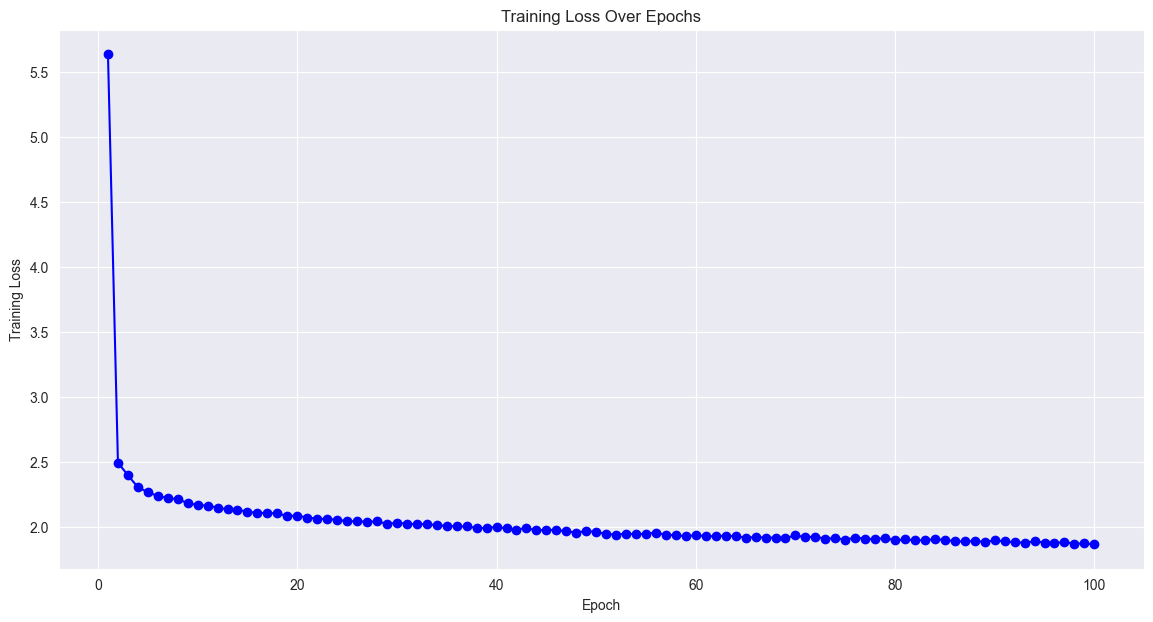

In [208]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

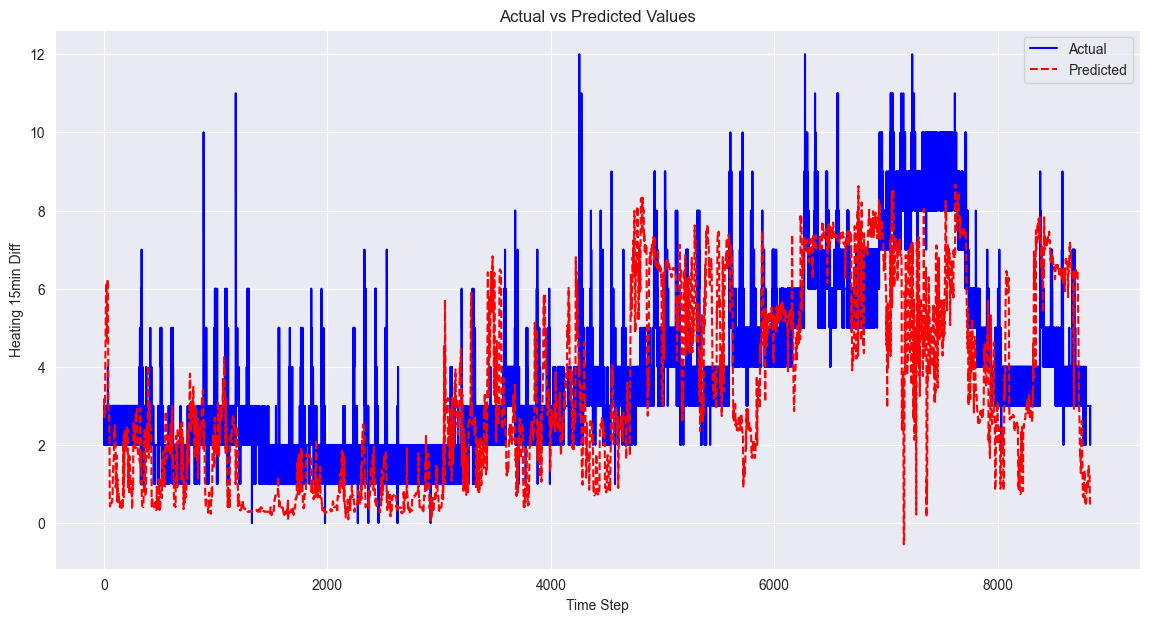

In [209]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Using data with holidays

In [210]:
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays.csv')

In [211]:
df = df.astype({'is_holiday': 'int32', 'day_of_week': 'int32', 'hour_of_day': 'int32', 'is_working_hour': 'int32'})

In [212]:
df

,DateTime,electricity_15min_diff,heating_15min_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction
0,2022-01-01 00:00:00,0.00,0.0,1,5,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0
1,2022-01-01 00:15:00,1.38,5.0,1,5,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0
2,2022-01-01 00:30:00,1.20,5.0,1,5,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0
3,2022-01-01 00:45:00,1.37,5.0,1,5,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0
4,2022-01-01 01:00:00,1.15,5.0,1,5,1,0,11.5,85.0,9.1,0.0,0.0,4.2,220.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35036,2022-12-31 23:00:00,2.12,3.0,1,5,23,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0
35037,2022-12-31 23:15:00,1.64,2.0,1,5,23,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0
35038,2022-12-31 23:30:00,1.87,3.0,1,5,23,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0
35039,2022-12-31 23:45:00,1.65,3.0,1,5,23,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0


In [213]:
df.keys()

Index(['DateTime', 'electricity_15min_diff', 'heating_15min_diff',
       'is_holiday', 'day_of_week', 'hour_of_day', 'is_working_hour',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction'],
      dtype='object')

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35041 entries, 0 to 35040
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DateTime                35041 non-null  object 
 1   electricity_15min_diff  35041 non-null  float64
 2   heating_15min_diff      35041 non-null  float64
 3   is_holiday              35041 non-null  int32  
 4   day_of_week             35041 non-null  int32  
 5   hour_of_day             35041 non-null  int32  
 6   is_working_hour         35041 non-null  int32  
 7   Temperature             35041 non-null  float64
 8   Humidity                35041 non-null  float64
 9   Dewpoint                35041 non-null  float64
 10  Sun Duration            35041 non-null  float64
 11  Precipitation Height    35041 non-null  float64
 12  Wind Speed              35041 non-null  float64
 13  Wind Direction          35041 non-null  float64
dtypes: float64(9), int32(4), object(1)
mem

In [215]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('DateTime', inplace=True)

In [216]:

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [217]:
# Drop rows with NaN values that may have been introduced by coercion
df.dropna(inplace=True)

In [218]:
# Define the date ranges for training and test data
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

In [219]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [220]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [221]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.numpy())
        predictions.extend(outputs.numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 5.7761
Epoch [2/100], avg_epoch_mse_loss:: 2.4365
Epoch [3/100], avg_epoch_mse_loss:: 2.3205
Epoch [4/100], avg_epoch_mse_loss:: 2.2378
Epoch [5/100], avg_epoch_mse_loss:: 2.1510
Epoch [6/100], avg_epoch_mse_loss:: 2.1046
Epoch [7/100], avg_epoch_mse_loss:: 2.0690
Epoch [8/100], avg_epoch_mse_loss:: 2.0497
Epoch [9/100], avg_epoch_mse_loss:: 2.0109
Epoch [10/100], avg_epoch_mse_loss:: 1.9902
Epoch [11/100], avg_epoch_mse_loss:: 1.9689
Epoch [12/100], avg_epoch_mse_loss:: 1.9468
Epoch [13/100], avg_epoch_mse_loss:: 1.9256
Epoch [14/100], avg_epoch_mse_loss:: 1.9258
Epoch [15/100], avg_epoch_mse_loss:: 1.9103
Epoch [16/100], avg_epoch_mse_loss:: 1.8955
Epoch [17/100], avg_epoch_mse_loss:: 1.8808
Epoch [18/100], avg_epoch_mse_loss:: 1.8752
Epoch [19/100], avg_epoch_mse_loss:: 1.8589
Epoch [20/100], avg_epoch_mse_loss:: 1.8552
Epoch [21/100], avg_epoch_mse_loss:: 1.8386
Epoch [22/100], avg_epoch_mse_loss:: 1.8264
Epoch [23/100], avg_epoch_mse_loss:: 1.82

In [222]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test mse Loss: 3.3192
Test MAE: 1.4259
Test R² Score: 0.3154


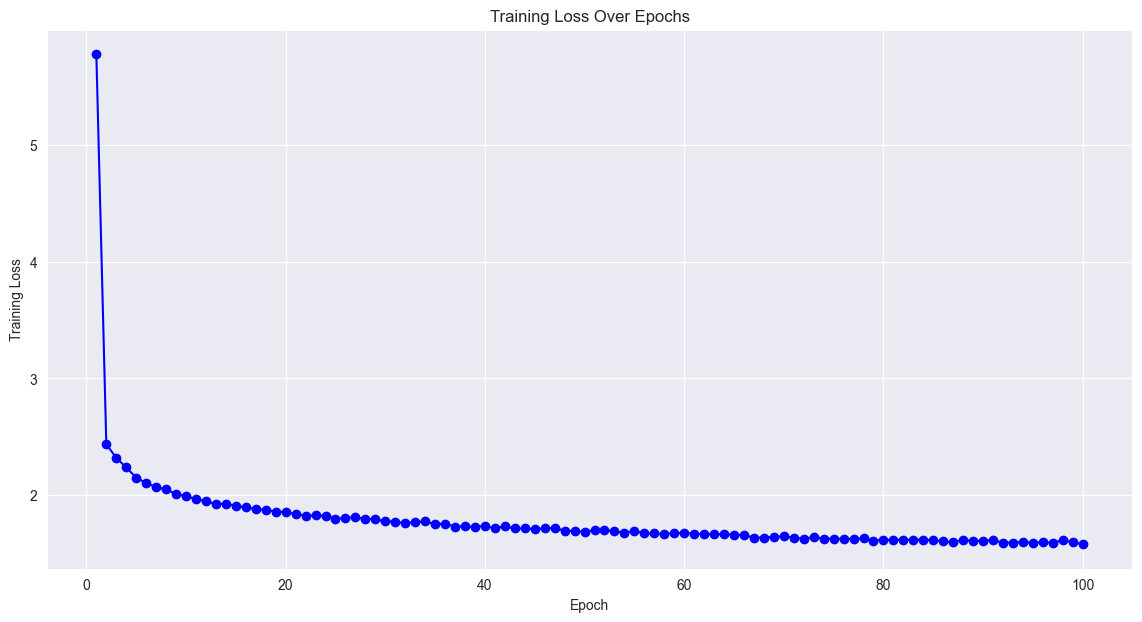

In [223]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

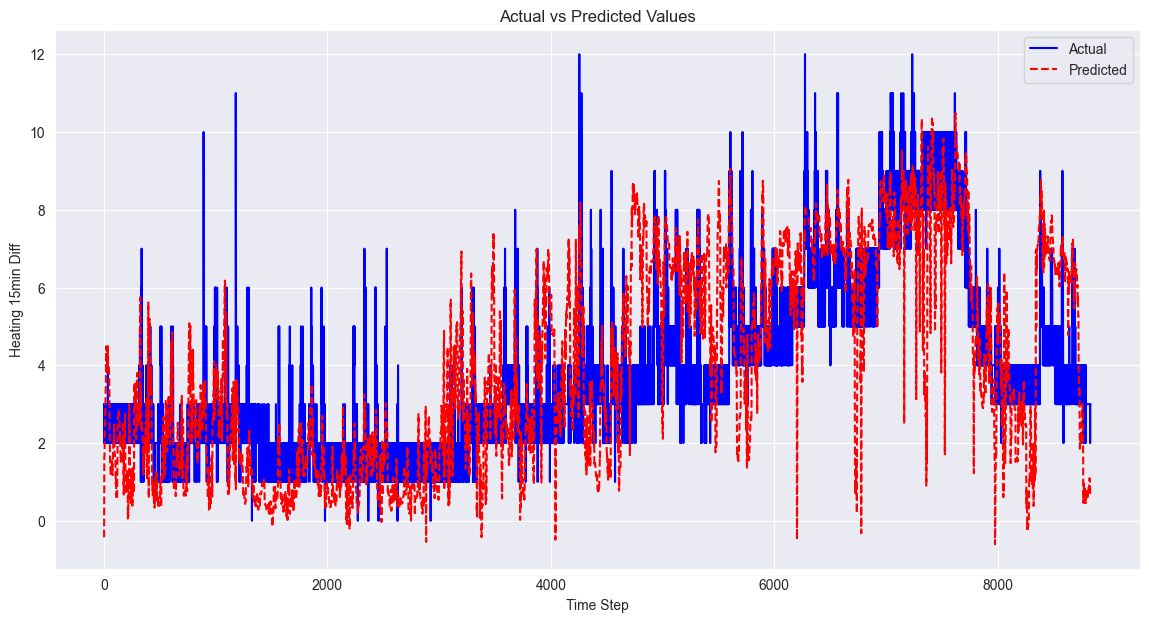

In [224]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Task2: electricity_15min_diff

## using weather data as features

In [229]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [230]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [231]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.1898
Epoch [2/100], avg_epoch_mse_loss:: 11.0091
Epoch [3/100], avg_epoch_mse_loss:: 10.9995
Epoch [4/100], avg_epoch_mse_loss:: 11.0063
Epoch [5/100], avg_epoch_mse_loss:: 10.9931
Epoch [6/100], avg_epoch_mse_loss:: 10.9968
Epoch [7/100], avg_epoch_mse_loss:: 10.9811
Epoch [8/100], avg_epoch_mse_loss:: 10.9724
Epoch [9/100], avg_epoch_mse_loss:: 10.9785
Epoch [10/100], avg_epoch_mse_loss:: 10.9703
Epoch [11/100], avg_epoch_mse_loss:: 10.9669
Epoch [12/100], avg_epoch_mse_loss:: 10.9746
Epoch [13/100], avg_epoch_mse_loss:: 10.9626
Epoch [14/100], avg_epoch_mse_loss:: 10.9581
Epoch [15/100], avg_epoch_mse_loss:: 10.9701
Epoch [16/100], avg_epoch_mse_loss:: 10.9514
Epoch [17/100], avg_epoch_mse_loss:: 10.9457
Epoch [18/100], avg_epoch_mse_loss:: 10.9549
Epoch [19/100], avg_epoch_mse_loss:: 10.9490
Epoch [20/100], avg_epoch_mse_loss:: 10.9483
Epoch [21/100], avg_epoch_mse_loss:: 10.9376
Epoch [22/100], avg_epoch_mse_loss:: 10.9413
Epoch [23/100], avg

In [232]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 1.1467
Test MAE: 0.7747
Test R² Score: -0.1547


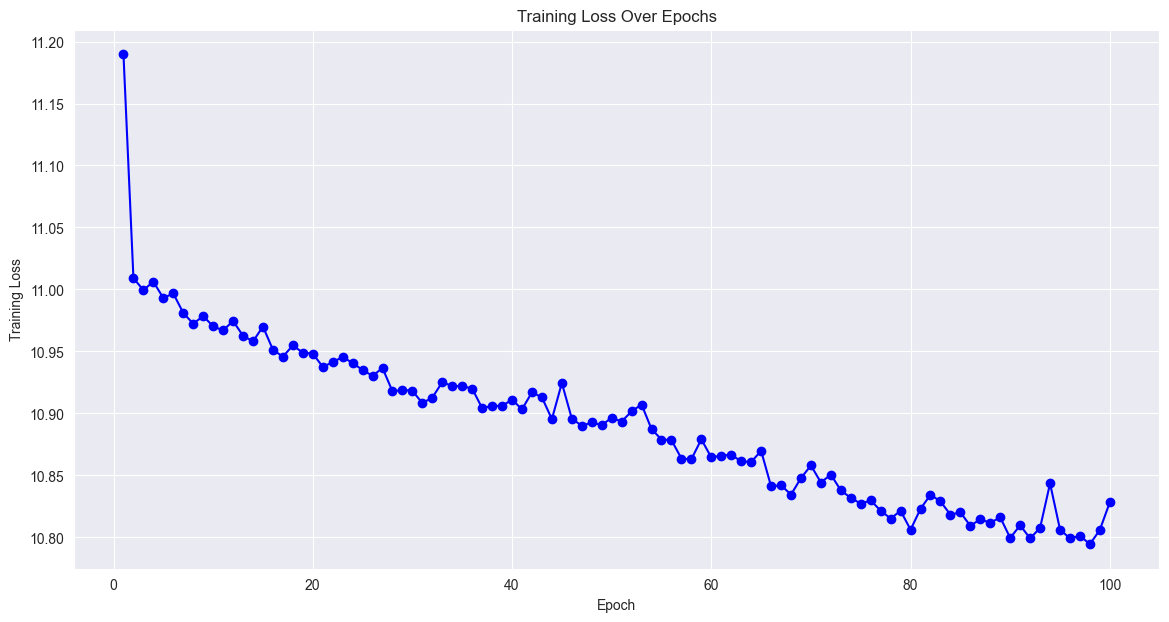

In [233]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

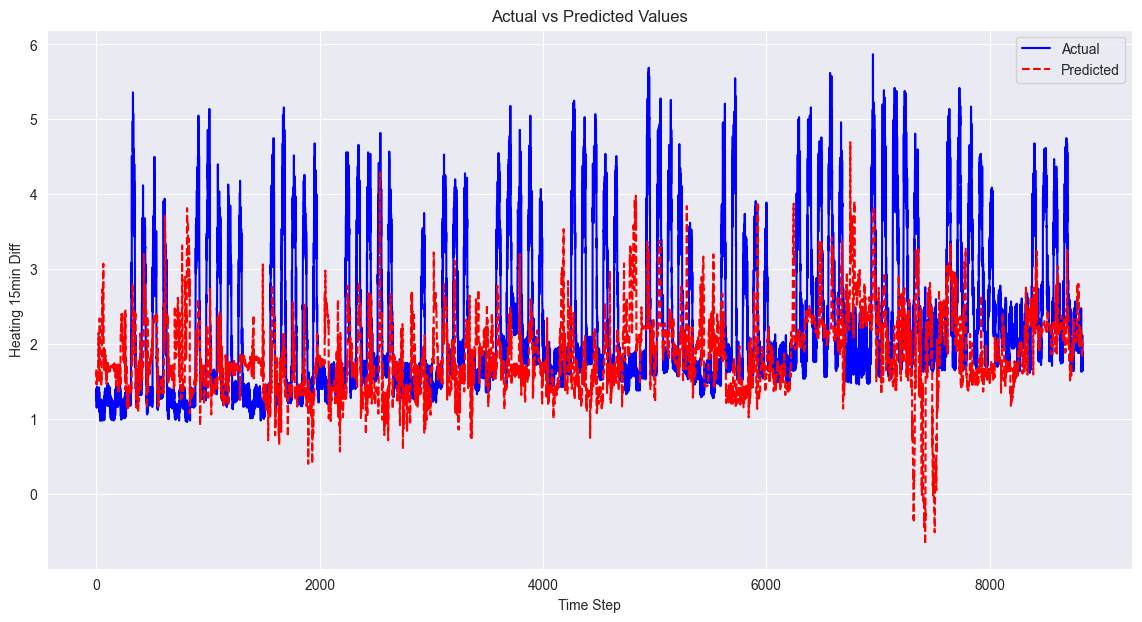

In [234]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using data with holidays

In [235]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [236]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [237]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.2088
Epoch [2/100], avg_epoch_mse_loss:: 10.6535
Epoch [3/100], avg_epoch_mse_loss:: 10.5577
Epoch [4/100], avg_epoch_mse_loss:: 10.5407
Epoch [5/100], avg_epoch_mse_loss:: 10.5159
Epoch [6/100], avg_epoch_mse_loss:: 10.5896
Epoch [7/100], avg_epoch_mse_loss:: 10.5085
Epoch [8/100], avg_epoch_mse_loss:: 10.5138
Epoch [9/100], avg_epoch_mse_loss:: 10.5014
Epoch [10/100], avg_epoch_mse_loss:: 10.5141
Epoch [11/100], avg_epoch_mse_loss:: 10.5008
Epoch [12/100], avg_epoch_mse_loss:: 10.4776
Epoch [13/100], avg_epoch_mse_loss:: 10.4661
Epoch [14/100], avg_epoch_mse_loss:: 10.4489
Epoch [15/100], avg_epoch_mse_loss:: 10.4691
Epoch [16/100], avg_epoch_mse_loss:: 10.4505
Epoch [17/100], avg_epoch_mse_loss:: 10.4489
Epoch [18/100], avg_epoch_mse_loss:: 10.4530
Epoch [19/100], avg_epoch_mse_loss:: 10.4571
Epoch [20/100], avg_epoch_mse_loss:: 10.4522
Epoch [21/100], avg_epoch_mse_loss:: 10.4284
Epoch [22/100], avg_epoch_mse_loss:: 10.4335
Epoch [23/100], avg

In [238]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 0.3673
Test MAE: 0.4515
Test R² Score: 0.6320


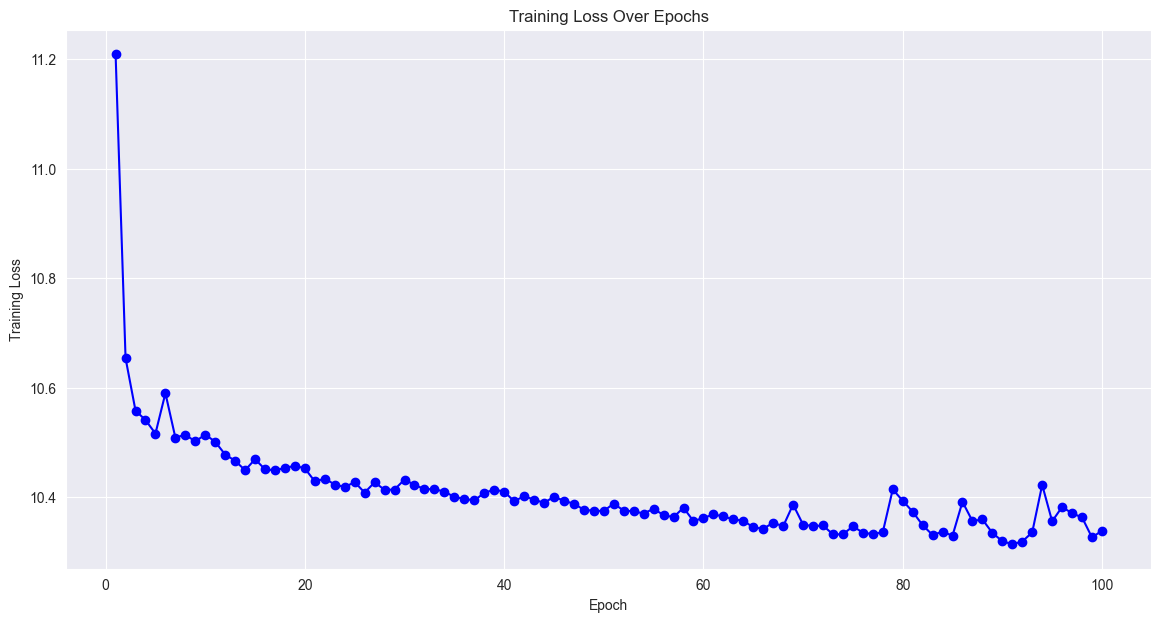

In [239]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

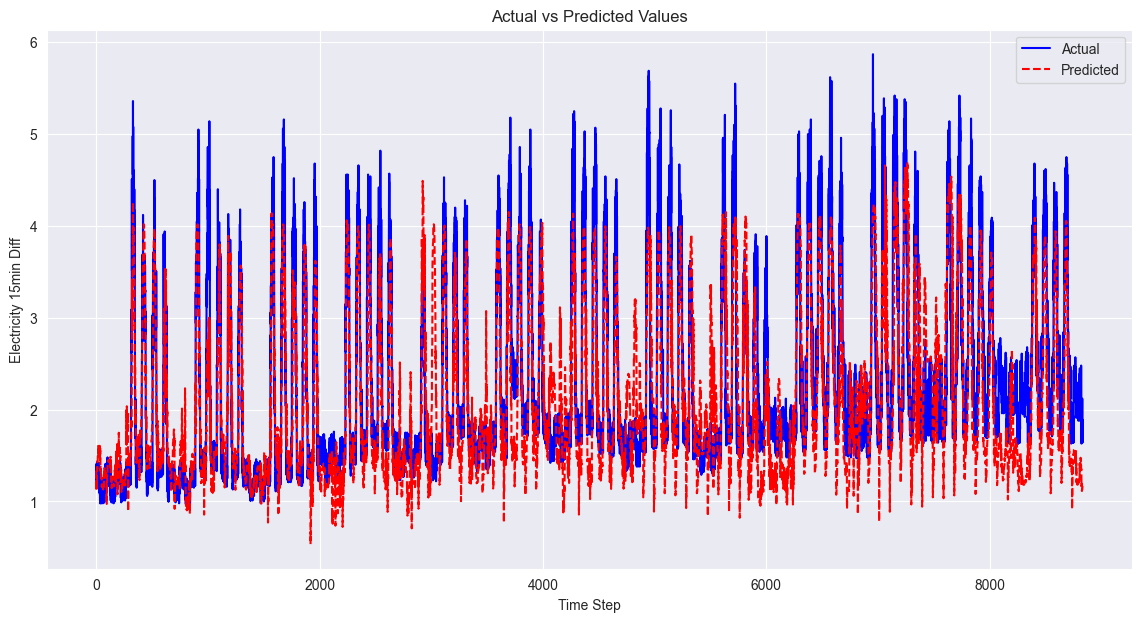

In [240]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()